# Neural Style Transfer

## Content Loss

In [1]:
from courses.deeplearning2.vgg16_avg import VGG16_Avg
from courses.deeplearning1.nbs.utils import *
from courses.deeplearning2.utils2 import *

%matplotlib inline

Using TensorFlow backend.
/home/matthew/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
!ls ./images

bridge.jpeg   city-painting.jpg     rembrandt.jpg     white-house.jpeg
bridge.png    landscape-1910.jpg    starry_night.jpg
city-day.jpg  mickeymouse.jpg	    trump.jpg
city.jpg      raphael-portrait.jpg  trump-small.jpg


In [3]:
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

def preprocess_img(img):
    processed = np.expand_dims(img.copy(), axis=0)
    processed.setflags(write=True)
    return preprocess_input(processed.astype(np.float64))

def deprocess_img(img, shape):
    processed = img.copy().reshape(shape)
    
    # Add back imagenet mean
    processed[:, :, 0] += 103.939
    processed[:, :, 1] += 116.779
    processed[:, :, 2] += 123.68
    
    processed = processed[:, :, ::-1]
    processed = np.clip(processed, 0, 255).astype('uint8')
    return processed

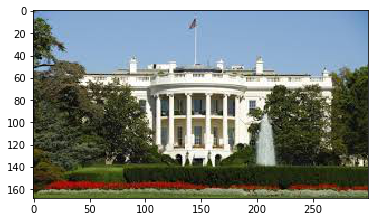

In [4]:
def load_and_process_img(img_path, display=True):
    img = image.load_img(img_path)
    unprocessed_img_shape = np.array(img).shape
    
    if display:
        plt.imshow(np.array(img))

    img_array = preprocess_img(img)
    processed_img_shape = img_array.shape
    processed_img_size = img_array.size
    
    return (img_array, unprocessed_img_shape, processed_img_shape, processed_img_size)

img_array, unprocessed_img_shape, processed_img_shape, processed_img_size = load_and_process_img('./images/white-house.jpeg')

In [5]:
model = VGG16_Avg(include_top=False)
print(model.summary())

/home/matthew/Code/dl/fastai/courses/deeplearning2/vgg16_avg.py:48: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv1", padding="same")`
  x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1')(img_input)
/home/matthew/Code/dl/fastai/courses/deeplearning2/vgg16_avg.py:49: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv2", padding="same")`
  x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2')(x)
/home/matthew/Code/dl/fastai/courses/deeplearning2/vgg16_avg.py:53: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="block2_conv1", padding="same")`
  x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv1')(x)
/home/matthew/Code/dl/fastai/courses/deeplearning2/vgg16_avg.py:54: UserWarning: Update your `Conv2

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (AveragePooling2 (None, None, None, 128)   0         
__________

In [6]:
def content_loss_and_grads(img, layer_name='block4_conv2'):
    layer = model.get_layer(layer_name).output
    intermediate_layer_model = Model(inputs=model.input, outputs=layer)
    target_activations = K.variable(intermediate_layer_model.predict(img))
    
    loss = K.sum(K.square(target_activations - layer))
    gradients = K.gradients(loss, model.input)
    
    return loss, gradients

In [7]:
from scipy.optimize import fmin_l_bfgs_b

class Evaluator:
    def __init__(self, func, shape):
        self.func = func
        self.shape = shape
    
    def get_loss(self, x):
        self.loss, self.grads = self.func([x.reshape(self.shape)])
        return self.loss.astype(np.float64)
    
    def get_grads(self, x):
        return self.grads.flatten().astype(np.float64)


def solve_image(x, iterations=10):
    loss, gradients = content_loss_and_grads(img_array)
    evaluator = Evaluator(K.function([model.input], [loss] + gradients), processed_img_shape)
    
    for i in range(iterations):
        print("Iteration {}".format(i))
        x, loss, info = fmin_l_bfgs_b(evaluator.get_loss, x.flatten(), fprime=evaluator.get_grads, maxfun=20)
        x = np.clip(x, -127, 127)
        print("Loss: ", loss)
        
    return x

In [8]:
def display_img(img, shape):
    plt.imshow(deprocess_img(img, shape))

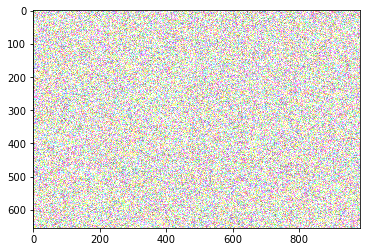

In [32]:
rand_img = lambda: preprocess_img(np.random.uniform(0, 255, processed_img_shape))
display_img(rand_img(), unprocessed_img_shape)

In [ ]:
solved = solve_image(rand_image())
display_img(solved, unprocessed_img_shape)

In [ ]:
Image.fromarray(deprocess_img(solved)).save("white_house_cnn.png", "PNG")
del solved

## Style Loss

In [ ]:
img_array, unprocessed_img_shape, processed_img_shape, processed_img_size = load_and_process_img('./images/starry_night.jpg')

In [9]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    return K.dot(features, K.transpose(features))

In [10]:
def style_loss(target, guess, denominator=1):
    return K.sum(K.square(gram_matrix(K.squeeze(target, axis=0)) - gram_matrix(K.squeeze(guess, axis=0)))) / denominator

def style_loss_and_grads(img, layer_names):
    layer_outputs = [model.get_layer(layer_name).output for layer_name in layer_names]
    intermediate_layer_model = Model(inputs=model.input, outputs=layer_outputs)
    target_activations = intermediate_layer_model.predict(img)
    
    loss_terms = []
    for target, guess in zip(target_activations, layer_outputs):
        num_filters = int(guess.shape[3])
        denominator =  4 * np.square(img.size) * np.square(num_filters)
        loss_terms.append(style_loss(K.variable(target), guess, denominator=denominator))
    
    loss = sum(loss_terms)
    gradients = K.gradients(loss, model.input)
    
    return loss, gradients

In [11]:
def extract_style(img, x,
                  style_layers=['block{}_conv1'.format(i + 1) for i in range(5)],
                  iterations=10):
    loss, gradients = style_loss_and_grads(img, style_layers) 
    evaluator = Evaluator(K.function([model.input], [loss] + gradients),
                          processed_img_shape)
    
    for i in range(iterations):
        print("Iteration {}".format(i))
        x, loss, info = fmin_l_bfgs_b(evaluator.get_loss, x.flatten(), fprime=evaluator.get_grads, maxfun=20)
        x = np.clip(x, -127, 127)
        print("Loss: ", loss)
        
    return x

In [12]:
from scipy.ndimage.filters import gaussian_filter

rand_blurred_img = lambda: preprocess_img(gaussian_filter(np.random.uniform(0, 255, processed_img_shape), [0, 2, 2, 0]))

In [ ]:
display_img(rand_blurred_img(), unprocessed_img_shape)

In [ ]:
style = extract_style(img_array, rand_blurred_img())
display_img(style, unprocessed_img_shape)

In [13]:
import os

def save_img(img, name, shape, directory='generated'):
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    Image.fromarray(deprocess_img(img, shape)).save("{}/{}.jpg".format(directory, name), "JPEG")

In [ ]:
Image.fromarray(deprocess_img(style, unprocessed_img_shape)).save("starry_night_style.png", "PNG")
del style

## Combined Loss

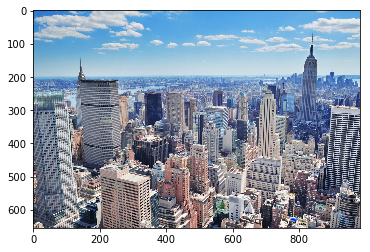

In [15]:
content_file_name = './images/city-day.jpg'
content_img_array, unprocessed_img_shape, processed_img_shape, processed_img_size = load_and_process_img(content_file_name)

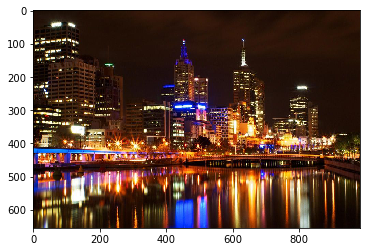

In [16]:
style_file_name = './images/city.jpg'
style_img = image.load_img(style_file_name, target_size=unprocessed_img_shape) 
plt.imshow(np.array(style_img))

style_img_array = preprocess_img(style_img)
assert style_img_array.shape == processed_img_shape

In [17]:
average_style_colors = [np.mean(style_img_array[0, :, :, i]) for i in range(3)]
average_content_colors = [np.mean(content_img_array[0, :, :, i]) for i in range(3)]

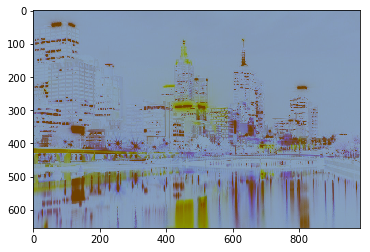

In [18]:
adjusted_style = style_img_array.copy()
for i in range(3):
    adjusted_style[0, :, :, i] *= average_content_colors[i] / average_style_colors[i] 
    
display_img(adjusted_style, unprocessed_img_shape)

In [19]:
def combined_loss_and_grads_fn(content_img, style_img,
                               content_weight,
                               content_layer_name='block4_conv2', style_layer_names=['block{}_conv1'.format(i + 1) for i in range(5)]):
    style_loss_val, _ = style_loss_and_grads(style_img, style_layer_names)
    content_loss_val, _ = content_loss_and_grads(content_img, content_layer_name)
    
    total_loss = content_weight * content_loss_val + style_loss_val
    gradients = K.gradients(total_loss, model.input)
    
    return K.function([model.input], [total_loss] + gradients)

In [20]:
def style_image(x, content_weight=1e-5, iterations=10):
    evaluator = Evaluator(combined_loss_and_grads_fn(content_img_array, style_img_array, content_weight),
                          processed_img_shape)
    
    for i in range(iterations):
        print("Iteration {}".format(i))
        x, loss, info = fmin_l_bfgs_b(evaluator.get_loss, x.flatten(), fprime=evaluator.get_grads, maxfun=20)
        x = np.clip(x, -127, 127)
        print("Loss: ", loss)
        
    return x

In [ ]:
styled = style_image(styled, content_weight=5e-6, iterations=500)
display_img(styled, unprocessed_img_shape)

Iteration 0
Loss:  27831.4882812
Iteration 1


In [ ]:
save_img(styled, 'day_to_night_v2', unprocessed_img_shape)

## Messing Around

In [ ]:
content_file_name = './images/trump-small.jpg'
content_img_array, unprocessed_img_shape, processed_img_shape, processed_img_size = load_and_process_img(content_file_name)

style_file_name = './images/mickeymouse.jpg'
style_img = image.load_img(style_file_name, target_size=unprocessed_img_shape) 
plt.imshow(np.array(style_img))

style_img_array = preprocess_img(style_img)
assert style_img_array.shape == processed_img_shape

In [ ]:
def funky_styling(img, layer_names):
    layer_outputs = [model.get_layer(layer_name).output for layer_name in layer_names]
    intermediate_layer_model = Model(inputs=model.input, outputs=layer_outputs)
    
    loss_terms = []
    for guess in layer_outputs:
        num_filters = int(guess.shape[3])
        denominator =  np.square(num_filters) * np.square(img.size)
        loss_terms.append(K.sum(K.square(guess)) / denominator)
    
    loss = sum(loss_terms)
    gradients = K.gradients(loss, model.input)
    
    return K.function([model.input], [loss] + gradients)

def style_image(x, content_weight=1e-5, iterations=10):
    evaluator = Evaluator(funky_styling(content_img_array, ['block{}_conv1'.format(i + 1) for i in range(5)]),
                          processed_img_shape)
    
    for i in range(iterations):
        print("Iteration {}".format(i))
        x, loss, info = fmin_l_bfgs_b(evaluator.get_loss, x.flatten(), fprime=evaluator.get_grads, maxfun=20)
        x = np.clip(x, -127, 127)
        print("Loss: ", loss)
        
    return x

In [ ]:
styled_weird = style_image(img_array, content_weight=1e-3, iterations=30)
display_img(styled_weird, unprocessed_img_shape)

In [ ]:
img_array.shape

In [ ]:
del styled